In [1]:
!pip install networkx
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.3/739.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 31.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for rexmex: filename=rexmex-0.1.3-py3-none-any.whl size=19951 sha256=1a3cd06a134cd8b9451ac669662db9cee69e17bd38330915f38cb588bca290cc
  Stored in directory: /root/.cache/pip/wheels/13/31/9d/51fb64454e6012bc88dd72b57609646432e478ba35772736d6
Successfully built rexmex


In [ ]:
!wget https://lnctard.bio-database.com/downloadfile/lnctard2.0.zip --no-check-certificate -qO- | zcat > lnctard2.0.txt

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pykeen
from pykeen.pipeline import pipeline
from pykeen.triples.leakage import Sealant
from pykeen.triples import TriplesFactory
from pykeen.hpo import hpo_pipeline

INFO:pykeen.utils:Using opt_einsum


In [3]:
def plot_degree(G):
    node_degrees = dict(G.degree())
    degree_values = list(node_degrees.values())

    plt.hist(degree_values, bins=range(min(degree_values), max(degree_values) + 1), alpha=0.7)
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.title('Degree Distribution')
    plt.show()

In [4]:
def plot_cc(G):
    connected_components = list(nx.strongly_connected_components(G))
    component_sizes = [len(component) for component in connected_components]  # 272, 1, 2, 3

    print(set(component_sizes))
    plt.hist(component_sizes, bins=range(min(component_sizes), max(component_sizes) + 1), alpha=0.7)
    plt.xlabel('Component Size')
    plt.ylabel('Count')
    plt.title('Connected Component Size Distribution')
    plt.show()

In [ ]:
# read LncTarD 2.0
lnctard = pd.read_csv("lnctard2.0.txt", sep="\t", header=0, encoding="latin-1")
lnctard = lnctard[["Regulator", "SearchregulatoryMechanism", "Target"]].drop_duplicates()
lnctard.to_csv("relations.txt", header=False, sep="\t", encoding="latin-1", index=False)
lnctard

,Regulator,SearchregulatoryMechanism,Target
0,LINC00313,ceRNA or sponge,miR-4429
1,FAM83H-AS1,epigenetic regulation,CDKN1A
2,NEAT1,ceRNA or sponge,TGFB1
3,NEAT1,ceRNA or sponge,ZEB1
4,ZFPM2-AS1,interact with protein,MIF
...,...,...,...
8353,LOXL1-AS1,ceRNA or sponge,MMP14
8354,HCG18,ceRNA or sponge,FGFR1
8355,IQANK1,ceRNA or sponge,MEF2D
8356,HCG22,ceRNA or sponge,miR-650


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(lnctard, *['SearchregulatoryMechanism'], **{})
chart

{272, 1, 2, 3}


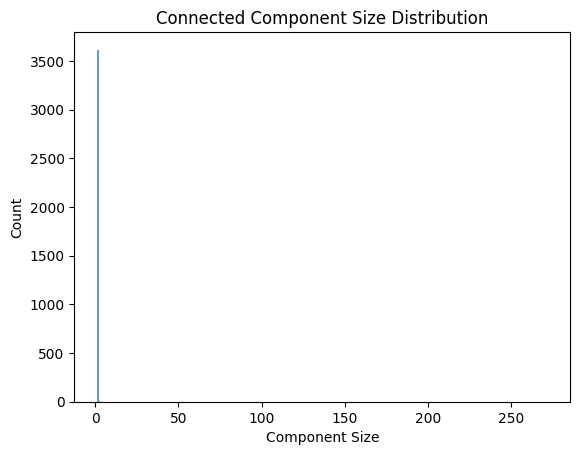

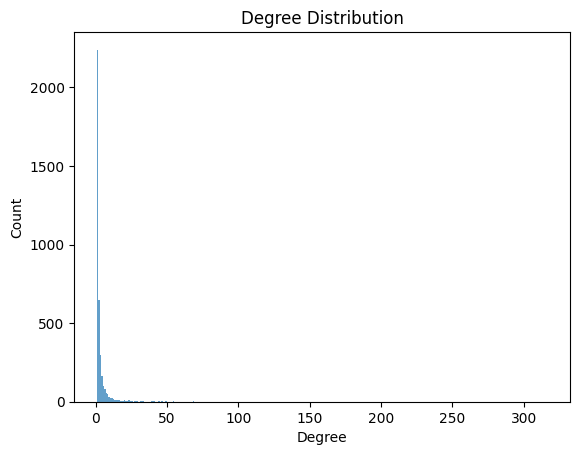

In [ ]:
# create graph
G = nx.DiGraph()
for _, row in lnctard.iterrows():
  G.add_edge(row['Regulator'], row['Target'], relation=row['SearchregulatoryMechanism'])
plot_cc(G)
plot_degree(G)

In [5]:
def plot_degrees(training, valid, test):
  training = training.tensor_to_df(tensor=training.mapped_triples)[["head_label", "relation_label", "tail_label"]]
  valid = valid.tensor_to_df(tensor=valid.mapped_triples)[["head_label", "relation_label", "tail_label"]]
  test = test.tensor_to_df(tensor=test.mapped_triples)[["head_label", "relation_label", "tail_label"]]

  G_training = nx.DiGraph()
  for _, row in training.iterrows():
    G_training.add_edge(row['head_label'], row['tail_label'], relation=row['relation_label'])
  degrees_training = list(dict(G_training.degree()).values())
  G_valid = nx.DiGraph()
  for _, row in valid.iterrows():
    G_valid.add_edge(row['head_label'], row['tail_label'], relation=row['relation_label'])
  degrees_valid = list(dict(G_valid.degree()).values())
  G_test = nx.DiGraph()
  for _, row in test.iterrows():
    G_test.add_edge(row['head_label'], row['tail_label'], relation=row['relation_label'])
  degrees_test = list(dict(G_test.degree()).values())


  plt.subplot(1, 3, 1)
  plt.title("Training Degree")
  plt.hist(degrees_training, bins=range(min(degrees_training), max(degrees_training) + 1), alpha=0.7)
  plt.subplot(1, 3, 2)
  plt.title("Valid Degree")
  plt.hist(degrees_valid, bins=range(min(degrees_valid), max(degrees_valid) + 1), alpha=0.7)
  plt.subplot(1, 3, 3)
  plt.title("Testing Degree")
  plt.hist(degrees_test, bins=range(min(degrees_test), max(degrees_test) + 1), alpha=0.7)

  plt.tight_layout()
  plt.show()


In [ ]:
tf = TriplesFactory.from_labeled_triples(lnctard.to_numpy())
training, valid, testing = tf.split([0.8, 0.1, 0.1], random_state=1234)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [2822, 744, 744]


In [ ]:
training.tensor_to_df(tensor=training.mapped_triples)[["head_label", "relation_label", "tail_label"]]

TriplesFactory(num_entities=3908, num_relations=7, create_inverse_triples=False, num_triples=5950)


,head_label,relation_label,tail_label
0,1700020I14Rik,ceRNA or sponge,CGRP
1,17beta-E2,transcriptional regulation,LINC01541
2,7SK,interact with protein,CDC6
3,91H,epigenetic regulation,H19
4,A1BG-AS1,ceRNA or sponge,SMAD7
...,...,...,...
5945,HOTTIP,ceRNA or sponge,HOXA13
5946,GHET1,expression association,VIM
5947,LINC00312,expression association,YBX1
5948,H19,ceRNA or sponge,CDK14


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_8, *['relation_label'], **{})
chart

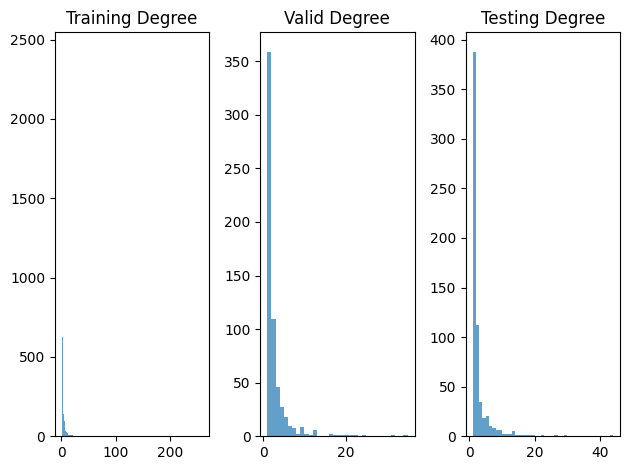

In [ ]:
plot_degrees(training, valid, testing)

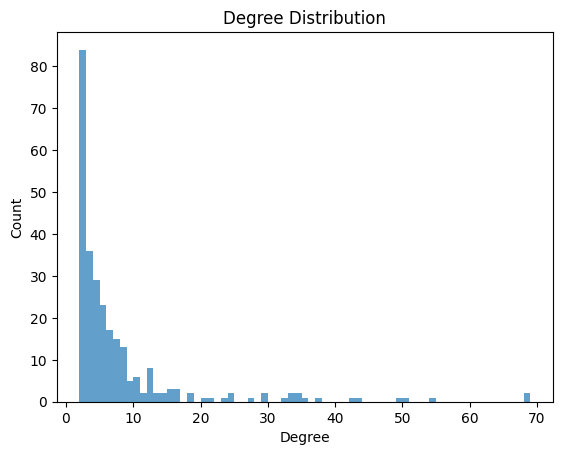

In [ ]:
# extract largest connected component
largest_connected_component = max(nx.strongly_connected_components(G), key=len)
G_sub = G.subgraph(largest_connected_component)
plot_degree(G_sub)

In [ ]:
# save largest connected component
edges = [(u, G_sub[u][v]['relation'], v) for u, v in G_sub.edges()]
result_df = pd.DataFrame(edges, columns=['Regulator', 'SearchregulatoryMechanism', 'Target'])
result_df.to_csv("relations_subgraph.csv", header=False, sep="\t", encoding="latin-1", index=False)
result_df

,Regulator,SearchregulatoryMechanism,Target
0,miR181a-5p,expression association,PVT1
1,PTEN,expression association,MALAT1
2,SMAD3,transcriptional regulation,HCP5
3,POU5F1,transcriptional regulation,NEAT1
4,POU5F1,transcriptional regulation,MALAT1
...,...,...,...
1012,MEG3,epigenetic regulation,EGFR
1013,MEG3,interact with protein,MYC
1014,PI3K,expression association,GAS5
1015,EZR-AS1,expression association,TGFB1


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(result_df, *['SearchregulatoryMechanism'], **{})
chart

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [548, 102, 102]


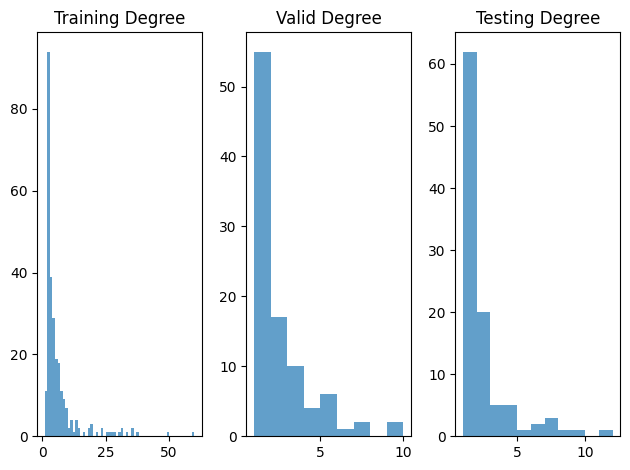

In [ ]:
tf_sub = TriplesFactory.from_labeled_triples(result_df.to_numpy())
training, valid, testing = tf_sub.split([0.8, 0.1, 0.1], random_state=1234)
plot_degrees(training, valid, testing)

In [ ]:
training.tensor_to_df(tensor=training.mapped_triples)[["head_label", "relation_label", "tail_label"]]

,head_label,relation_label,tail_label
0,ABHD11-AS1,interact with protein,RHOC
1,ADAMTS9-AS2,ceRNA or sponge,EZH2
2,AGAP2-AS1,expression association,MEG3
3,AGO2,ceRNA or sponge,PTEN
4,AR,transcriptional regulation,DRAIC
...,...,...,...
808,DRAIC,expression association,NFKB1
809,MALAT1,interact with protein,SP1
810,SP1,transcriptional regulation,TINCR
811,E2F1,transcriptional regulation,SNHG1


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_9, *['relation_label'], **{})
chart

In [ ]:
valid.tensor_to_df(tensor=valid.mapped_triples)[["head_label", "relation_label", "tail_label"]]

,head_label,relation_label,tail_label
0,LINC00511,ceRNA or sponge,EZH2
1,LUCAT1,expression association,EZH2
2,MALAT1,ceRNA or sponge,miR-497
3,CCAT2,expression association,ZBTB7A
4,CRNDE,interact with protein,EZH2
...,...,...,...
97,H19,ceRNA or sponge,COL1A1
98,PART1,ceRNA or sponge,DNMT3A
99,CCAT2,expression association,TP53
100,NEAT1,ceRNA or sponge,YY1


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_12, *['relation_label'], **{})
chart

In [ ]:
testing.tensor_to_df(tensor=testing.mapped_triples)[["head_label", "relation_label", "tail_label"]]

,head_label,relation_label,tail_label
0,ADAMTS9-AS2,ceRNA or sponge,FOXO1
1,TUG1,expression association,POU2F1
2,MEG3,epigenetic regulation,EZH2
3,PVT1,ceRNA or sponge,miR-497
4,MALAT1,interact with protein,BIRC7
...,...,...,...
97,MIR31HG,interact with protein,EZH2
98,NEAT1,expression association,MYC
99,MALAT1,epigenetic regulation,PCDH10
100,CYTOR,expression association,CTNNB1


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_11, *['relation_label'], **{})
chart

In [6]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
weakly_cc = pd.read_csv("drive/MyDrive/GuidedResearch/relations_subgraph.csv", sep="\t", header=None)
weakly_cc

,0,1,2
0,LINC00313,ceRNA or sponge,MIR4429
1,LINC00313,transcriptional regulation,SOX2
2,LINC00313,ceRNA or sponge,MIR422A
3,LINC00313,ceRNA or sponge,FOSL2
4,LINC00313,epigenetic regulation,ALX4
...,...,...,...
6080,KDM4A-AS1,ceRNA or sponge,KPNA2
6081,LINC00491,ceRNA or sponge,ROCK1
6082,LAMTOR5-AS1,interact with protein,GABPA
6083,HSPA7,ceRNA or sponge,MIR223


In [8]:
tf = TriplesFactory.from_labeled_triples(weakly_cc.to_numpy())
training, valid, testing = tf.split([0.8, 0.1, 0.1], random_state=1234)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [2631, 608, 609]


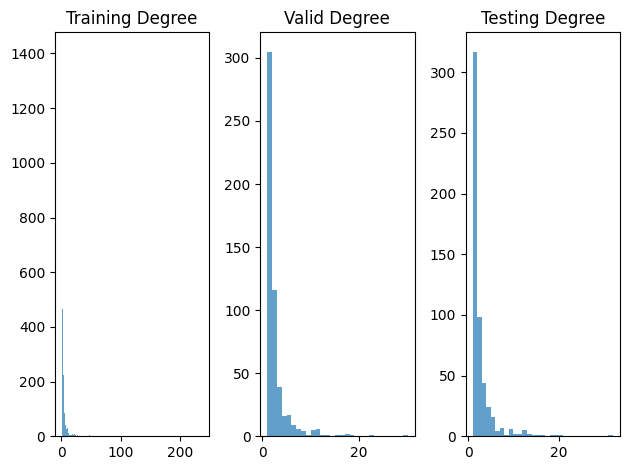

In [9]:
plot_degrees(training, valid, testing)

In [10]:
training.tensor_to_df(tensor=training.mapped_triples)[["head_label", "relation_label", "tail_label"]]

,head_label,relation_label,tail_label
0,A1BG-AS1,ceRNA or sponge,SMAD7
1,AATBC,expression association,CASP3
2,AATBC,expression association,CASP9
3,AATBC,expression association,CDKN2C
4,AATBC,expression association,MAPK8
...,...,...,...
4863,HULC,interact with protein,AKT1
4864,CRNDE,expression association,SMAD3
4865,MIR4435-2HG,ceRNA or sponge,WWTR1
4866,YY1,transcriptional regulation,CASC9


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_0, *['relation_label'], **{})
chart

In [11]:
valid.tensor_to_df(tensor=valid.mapped_triples)[["head_label", "relation_label", "tail_label"]]

,head_label,relation_label,tail_label
0,MALAT1,ceRNA or sponge,AKT3
1,PCBP2-OT1,interact with mRNA,RASAL1
2,LOXL1-AS1,ceRNA or sponge,USF1
3,LINC01433,ceRNA or sponge,STAT3
4,LINC00963,ceRNA or sponge,HMGA1
...,...,...,...
603,CCAT1,ceRNA or sponge,HMGA2
604,HOTAIR,ceRNA or sponge,MIR217
605,PVT1,epigenetic regulation,STAT1
606,TGFB1,interact with protein,MIR155HG


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_1, *['relation_label'], **{})
chart

In [12]:
testing.tensor_to_df(tensor=testing.mapped_triples)[["head_label", "relation_label", "tail_label"]]

,head_label,relation_label,tail_label
0,NEAT1,expression association,BAX
1,ICMT-DT,interact with protein,EZH2
2,TPTEP1,transcriptional regulation,STAT3
3,SLC26A4-AS1,expression association,VIM
4,MIR22HG,transcriptional regulation,MYC
...,...,...,...
604,HULC,expression association,SNAI1
605,HAND2-AS1,expression association,ROCK2
606,TTN-AS1,ceRNA or sponge,NRP1
607,LINC00707,interact with protein,ELAVL1


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['relation_label'], **{})
chart

In [13]:
training.tensor_to_df(tensor=training.mapped_triples)[["head_label", "relation_label", "tail_label"]].to_csv("train.txt", header=False, sep="\t", index=False)
valid.tensor_to_df(tensor=valid.mapped_triples)[["head_label", "relation_label", "tail_label"]].to_csv("valid.txt", header=False, sep="\t", index=False)
testing.tensor_to_df(tensor=testing.mapped_triples)[["head_label", "relation_label", "tail_label"]].to_csv("test.txt", header=False, sep="\t", index=False)